In [32]:
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import distance

sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

from source import const

In [4]:
%matplotlib notebook

pgp_file = "../datasets/Table_S1_pgp1_data_table.csv"
pgp_data = pd.read_csv(pgp_file,index_col=False)


In [6]:
cells = []
cell_indices = pgp_data["cell_id"].unique()

for cell_index in cell_indices:
    cells.append(pgp_data.loc[pgp_data["cell_id"] == cell_index])

In [25]:
def build_empty_matrix(bins):

    M = []
    for i in range(bins):
        M.append([])
        for j in range(bins):
            M[i].append([np.nan])

    return(M)
def get_B_vector(cn,resolution):
    chr_size = sizes[cn]
    num_bins = int(np.floor(chr_size/resolution)+1)
    B = np.arange(0,num_bins)
    return B

def get_cdist(c1, c2):

    X1 = np.array([[row["x_um"],row["y_um"],row["z_um"]] for index, row in c1.iterrows()])
    X2 = np.array([[row["x_um"],row["y_um"],row["z_um"]] for index, row in c2.iterrows()])
    
    P1 = [row["hg38_pos"] for index, row in c1.iterrows()]
    P2 = [row["hg38_pos"] for index, row in c2.iterrows()]

    X_cdist = distance.cdist(X1,X2)

    return (X_cdist, P1, P2)

def populate_tile(GM, cni, cnj, ci, cj, resolution):

    B1 = get_B_vector(cni,resolution)
    B2 = get_B_vector(cnj,resolution)
    (X_cdist, P1, P2) = get_cdist(ci, cj)
    
    
    P1_inds = np.digitize(P1, B1*resolution)-1
    P2_inds = np.digitize(P2, B2*resolution)-1
    
    offset1 = np.sum(bin_sizes_chr[:cni])
    offset2 = np.sum(bin_sizes_chr[:cnj])
    
    for i in range(X_cdist.shape[0]):
        for j in range(X_cdist.shape[1]):
            ii = P1_inds[i] + offset1 
            jj = P2_inds[j] + offset2
            if X_cdist[i][j] == 0: continue
            GM[ii][jj].append((X_cdist[i][j]))
            GM[jj][ii].append((X_cdist[i][j]))

    return GM


In [26]:
resolution = 10*10**6
sizes = const.SIZES_HG38
chr_count = len(sizes) # minus allosomes
bin_sizes_chr = []

for i in range(0, chr_count):
    chr_size = sizes[i]
    num_bins = int(np.floor(chr_size/resolution)+1)
    bin_sizes_chr.append(num_bins)

bin_sizes_chr = np.array(bin_sizes_chr)
bin_sizes_chr[0] = 0
total_bins = np.sum(np.array(bin_sizes_chr))

In [34]:
sum_sizes = [0]

for i in range(1, len(bin_sizes_chr)):
    sum_sizes.append(sum_sizes[i-1] + bin_sizes_chr[i])

In [29]:
GM = build_empty_matrix(total_bins)
for cell in cells:
    for i in range(1,chr_count):
        for j in range(i,chr_count):
            if i == j:
                cluster = cell.loc[cell["hg38_chr"] == i]
                cluster_idxs = cluster["mle_cluster"].unique()
                
                for idx in cluster_idxs:
                
                    ci = cluster.loc[cluster["mle_cluster"]==idx]
                    
                    if not len(ci) > 1: continue
                                    
                    cj = cluster.loc[cluster["mle_cluster"]==idx]
                    GM = populate_tile(GM, i, j, ci, cj,resolution)
            else:
                ci = cell.loc[cell["hg38_chr"] == i]
                cj = cell.loc[cell["hg38_chr"] == j]
                if not len(ci) > 0: continue
                if not len(cj) > 0: continue
                GM = populate_tile(GM, i, j, ci, cj,resolution)

In [30]:
def flatten_matrix(M):

    L = len(M)
    flat_M = np.zeros((L,L))

    for i in range(L):
        for j in range(L):
            if len(M[i][j]) > 1:
                flat_M[i][j] = np.nanmedian(M[i][j])
            else:
                flat_M[i][j] = np.nan

    return flat_M

meanM = flatten_matrix(GM)

<IPython.core.display.Javascript object>


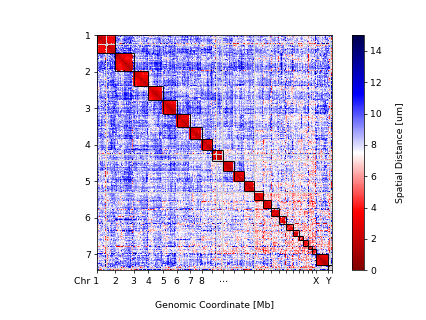

0.48448867399206885


(322.0, 0.0)

In [33]:
def plot_matrix(M,title="", clim=(2,18),label = '\nSpatial Distance [um]'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    res = resolution / 10**6
    #extent = [0, res*len(M), res*len(M),0]
    #cax = ax.matshow(M,cmap='Reds_r') 
    #cax = ax.matshow(M,cmap='coolwarm_r') 
    #cax = ax.matshow(M, cmap='seismic_r')
    cmap = plt.get_cmap('seismic_r')
    cmap.set_bad(color='lightgrey')

    for i in range(2, chr_count+1):
        offset0 = np.sum(bin_sizes_chr[:i-1])#*10
        offset1 = np.sum(bin_sizes_chr[:i])#*10-1
        
        ax.hlines(offset0-1,offset0,offset1, lw=1, color='black')
        ax.hlines(offset1-1,offset0,offset1, lw=1, color='black')
        ax.vlines(offset0,offset0-1,offset1-1, lw=1, color='black')
        ax.vlines(offset1,offset0-1,offset1-1, lw=1, color='black')

    print(np.nanmin(M))
    
    cax = ax.imshow(M,cmap=cmap,interpolation='nearest')#, extent=extent)#, norm=mpl.colors.LogNorm()) 
    
    cbar = fig.colorbar(cax, label=label)#,ticks = [3,6,12,24])#,ticks = [0,3,6,9,12,15,18,21])
    ax.set_xlabel("\nGenomic Coordinate [Mb]")
    cax.set_clim(clim)
    
    plt.xticks(sum_sizes)
    
    x_tick_labels = ["Chr 1       "]
    y_tick_labels = ["1"]
    
    for i in range(2,25):
        if i == 23:
            x_tick_labels.append("X")
            y_tick_labels.append("X")
        elif i == 24:
            x_tick_labels.append("Y")
            y_tick_labels.append("Y")
        elif i > 1 and i < 9:
            x_tick_labels.append(str(i))
            y_tick_labels.append(str(i))
        elif i == 10:
            x_tick_labels.append(str(" ⋯ "))
            y_tick_labels.append(str(""))
            #y_tick_labels.append(str(".\n.\n.\n"))
        else:
            x_tick_labels.append(str(""))
            y_tick_labels.append(str(""))
            
    ax.set_title(title + "\n")
    ax.set_xticklabels(x_tick_labels)#ax.get_xticks().astype(int)*bin_size//1000000)
    ax.set_yticklabels(y_tick_labels)#ax.get_yticks().astype(int)*bin_size//1000000)
    
    ax.set_title(title + "\n")
    plt.tight_layout()
    plt.show()   
    
    return fig, ax


fig, ax = plot_matrix(meanM,clim=(0,15))

ax.set_xlim(0,322)
ax.set_ylim(322,0)

In [13]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [163]:
plt.savefig("pgp_matrix.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0)